# Mounting on google

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

# Imports

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, pickle, os, time
import argparse 
import pprint
import random
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from __future__ import print_function
import torch, os, copy, time, pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import glob, pickle
import seaborn as sn
import argparse
start_time= time.time()
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from skimage.io import imread
import PIL

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
start_time= time.time()

# Preprocessing

## Transformers

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) , 
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

In [7]:
data_dir='/content/gdrive/MyDrive/DL_course/project/Dataset/new/data2/'

In [8]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}       

## Data loaders

In [9]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= 20,
                                             shuffle=True, num_workers= 0)
              for x in ['train', 'test']}

In [10]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [11]:
class_names = image_datasets['train'].classes  

In [12]:
def imshow(inp, title= None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Setting Device to cuda (if applicable)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train funcion

In [14]:
def train_model(model, criterion, optimizer, scheduler, batch_szie, num_epochs= 1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= list()
    valid_acc= list()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterate over data.
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_szie
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    valid_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model_wts = copy.deepcopy(model.state_dict())



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch) )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, valid_acc

In [15]:
def visualize_model(model, num_images= 64):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images/8, 8, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Model

## hyper parameters

In [16]:
epochs = 30
batch_size = 16
dropout_rate = 0.5

## Load squeezenet

In [17]:
model_conv = torchvision.models.squeezenet1_0(pretrained=True)
for param in model_conv.features.parameters():
    param.requires_grad = False

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Fine Tuning

In [18]:
# Parameters of newly constructed modules have requires_grad=True by default   
# num_ftrs = model_conv.classifier.in_features        
model_conv.classifier =nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Conv2d(512, 16, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1))
)



model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './squeznet.pt')

Epoch 1/30
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Streaming output truncated to the last 5000 lines.
label: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0])
27-th epoch, 111-th batch (size=20), train acc= 1.188 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0])
27-th epoch, 112-th batch (size=20), train acc= 1.250 


preds: tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label: tensor([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
27-th epoch, 113-th batch (size=20), train acc= 1.250 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0])
27-th epoch, 114-th batch (size=20), train acc= 1.188 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
27-th epoch, 115-th batch (size=20), 

In [19]:
end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)

total_time tranfer learning= 11783.700639486313


# Testing

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
model= torch.load('squeznet.pt', map_location='cpu') 
model.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [22]:
def Confusion_Matrix(y_pred_list , y_test_list):
  y_pred= np.asarray(y_pred_list, dtype=np.int64)
  y_test= np.asarray(y_test_list, dtype=np.int64)
  cnf_matrix = confusion_matrix(y_test, y_pred)
  np.set_printoptions(precision=2)   
  df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                                 columns = [i for i in class_names])
  ax = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['COVID','Non-COVID'], yticklabels= ['COVID','Non-COVID'])
  ax.set_title("Confusion matrix")

In [23]:
def test(data , threshold):
  num_coivd_preds = 0
  num_non_covid_preds = 0
  preds = []
  labels = []

  for  image, label in data :
    img = image.reshape(1, 3 , 224, 224)
    output = model(img)
    pred = torch.nn.Softmax()(output)

    if float(pred[0][0]) > threshold:
      preds.append(0)
      num_coivd_preds += 1
    else:
      preds.append(1)
      num_non_covid_preds += 1

    labels.append(label)

  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i in range(3100):
    if labels[i] == 0 and preds[i] == 0:
      TN += 1
    elif labels[i] == 0 and preds[i] == 1:
      FP += 1
    elif labels[i] == 1 and preds[i] == 1:
      TP += 1
    elif labels[i] == 1 and preds[i] == 0:
      FN += 1

  print("TP = ", TP)
  print("FP = ", FP)
  print("TN = ", TN)
  print("FN = ", FN)
  
  sensivity = (100 - FP) / 100
  Specificity =  (3000 - FN) / 3000

  print('Sensitivity = :',sensivity)
  print('Specificity = :', Specificity)

  Confusion_Matrix(preds , labels)

  return num_coivd_preds, num_non_covid_preds

In [24]:
def plot_probabilty_dist(covid_prob ,non_prob ):
  bins = np.linspace(0, 1, 25)
  plt.subplot(211)
  plt.hist(covid_prob, bins, color= 'blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
  plt.ylim([0,10])
  plt.legend(loc='upper center')
  plt.subplot(212)
  plt.hist(non_prob, bins, color= 'green', label='Probabilities of Non-COVID Samples')
  plt.legend(loc='upper center')
  plt.savefig('./scores_histogram.png')

In [25]:
def ROC_AUC(covid_prob ,non_covid_prob ,coivd_pred,non_covid_pred, cut_off_threshold):
  y_test_res18= [1 for i in range(len(covid_prob))]+[0 for i in range(len(non_covid_prob))]
  y_pred_res18= [1 for i in range(coivd_pred)]+[0 for i in range(non_covid_pred)]

           
  auc_res18 = roc_auc_score(y_test_res18, y_pred_res18)
  ns_fpr_res18, ns_tpr_res18, _ = roc_curve(y_test_res18, y_pred_res18)

  plt.figure()
  pyplot.plot(ns_fpr_res18, ns_tpr_res18,  color='darkgreen', linewidth=2,   label='   AUC= %.3f'   %auc_res18) 
  pyplot.ylim([0,1.05])
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.title("ROC Curve threshold is %.2f "  %cut_off_threshold)
  pyplot.legend(loc='lower right')

In [26]:
def compute_prob(data):
  covid_prob = []
  non_covid_prob = []

  for  image, label in data :
    img = image.reshape(1, 3 , 224, 224)
    output = model(img)
    pred = torch.nn.Softmax()(output)

    if label == 0 :
        covid_prob.append(pred.data.numpy()[0,0])
    if label == 1 :
        non_covid_prob.append(pred.data.numpy()[0,0])
  
  return covid_prob, non_covid_prob

<ipython-input-26-26bf5dfc0595>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.Softmax()(output)


******************** plot the predicted probability distribution ********************




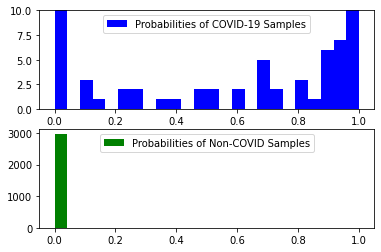

==================== 0.1 ====================



******************** derive confusion-matrix ********************




<ipython-input-23-55234b1303e6>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.Softmax()(output)


TP =  2986
FP =  12
TN =  88
FN =  14
Sensitivity = : 0.88
Specificity = : 0.9953333333333333


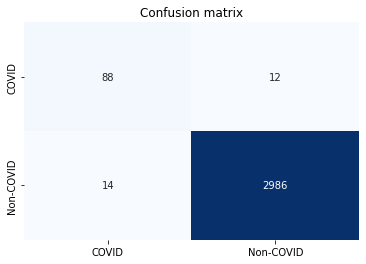



******************** ROC Curve and AUC ********************




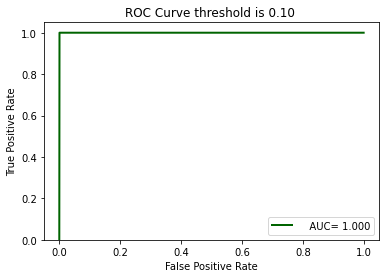

==================== 0.15 ====================



******************** derive confusion-matrix ********************




<ipython-input-23-55234b1303e6>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.Softmax()(output)


TP =  2988
FP =  13
TN =  87
FN =  12
Sensitivity = : 0.87
Specificity = : 0.996


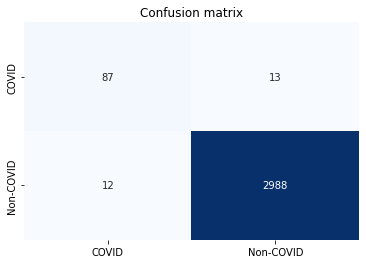



******************** ROC Curve and AUC ********************




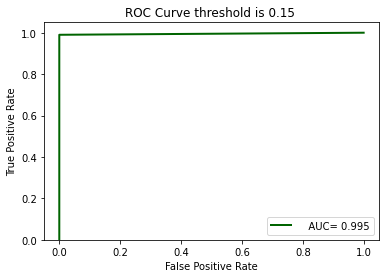

==================== 0.2 ====================



******************** derive confusion-matrix ********************




<ipython-input-23-55234b1303e6>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.Softmax()(output)


TP =  2990
FP =  14
TN =  86
FN =  10
Sensitivity = : 0.86
Specificity = : 0.9966666666666667


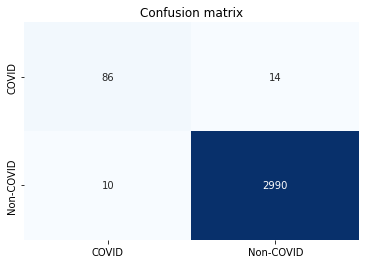



******************** ROC Curve and AUC ********************




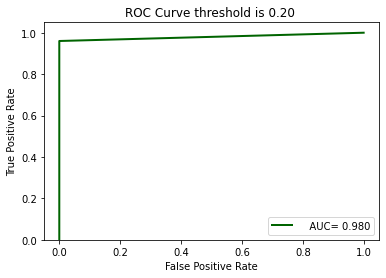

==================== 0.4 ====================



******************** derive confusion-matrix ********************




<ipython-input-23-55234b1303e6>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.Softmax()(output)


TP =  2994
FP =  20
TN =  80
FN =  6
Sensitivity = : 0.8
Specificity = : 0.998


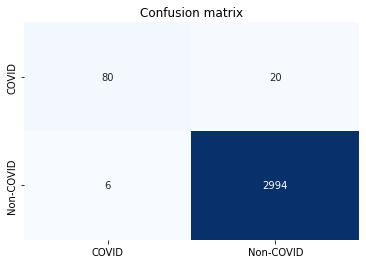



******************** ROC Curve and AUC ********************




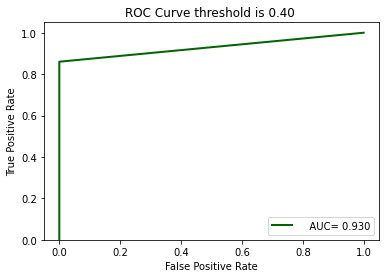

==================== 0.5 ====================



******************** derive confusion-matrix ********************




<ipython-input-23-55234b1303e6>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.Softmax()(output)


TP =  2997
FP =  22
TN =  78
FN =  3
Sensitivity = : 0.78
Specificity = : 0.999


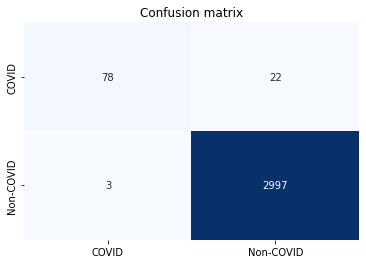



******************** ROC Curve and AUC ********************




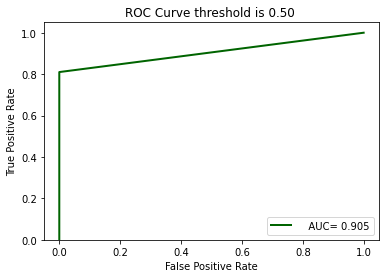

In [27]:
covid_prob, non_covid_prob = compute_prob(image_datasets['test'])

print("*" * 20, end=' ')
print("plot the predicted probability distribution", end=' ')
print("*" * 20)

print("\n" * 1)

plot_probabilty_dist(covid_prob , non_covid_prob)
plt.show()

for threshold in [0.1 ,0.15 ,0.2 ,0.4 ,0.5]:
  print("=" * 20, end=' ')
  print(threshold, end=' ')
  print("=" * 20)

  print("\n" * 2)

  print("*" * 20, end=' ')
  print("derive confusion-matrix", end=' ')
  print("*" * 20)

  print("\n" * 1)

  num_coivd_preds , num_non_covid_preds = test(image_datasets['test'] , threshold)
  plt.show()

  print("\n" * 1)

  print("*" * 20, end=' ')
  print("ROC Curve and AUC", end=' ')
  print("*" * 20)

  print("\n" * 1)

  ROC_AUC(covid_prob, non_covid_prob, num_coivd_preds, num_non_covid_preds, threshold)
  plt.show()